Functions

In [889]:
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter

import numpy as np

import os

from scipy import optimize
import scipy.constants as cst
from scipy.signal.signaltools import wiener

from scipy.interpolate import interp1d

In [890]:
from pylab import *
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Polygon
import scipy.constants as cst
from astropy.io import ascii, fits
from scipy.signal.signaltools import wiener
from astropy.convolution import Gaussian1DKernel, convolve

fig_width_pt = 469.75499                # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width * golden_mean * 1.1   # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'pdf',
          'axes.linewidth': 1.5,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.labelsize': 16,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'lines.dash_joinstyle' : 'round',
          'lines.dash_capstyle' : 'round',
          'lines.solid_joinstyle' : 'round',
          'lines.solid_capstyle' : 'round',
          'text.usetex': False,
          'mathtext.fontset' : 'stixsans',
          'mathtext.default' : 'rm',
          'xtick.direction' : 'in',
          'ytick.direction' : 'in',
          'xtick.top' : False,
          'ytick.right' : False,
          'figure.figsize': fig_size}
rcParams.update(params)

In [891]:
def extract_elliptical_spectrum(galaxy_name, line_name, PI_name, ver, 
                                n, central_wav, center_x, center_y, r_x, r_y, theta, corrected):
    
    
    #rootdir contains the datacube
    
    rootdir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/Raw/' + galaxy_name + '/' + line_name + '/' + PI_name + '/'
    
    if(ver != ''):
        rootdir = rootdir + ver + '/'
        
    fits_name = galaxy_name + '_' + line_name + '.fits'
    
    #hdulist is the datacube
    
    hdulist = fits.open(rootdir + fits_name)
    
    #loaddir contains the 1-D spectrum

    loaddir = rootdir + 'r_x=' + str(r_x) + ',r_y=' + str(r_y) + ',theta=' + str(theta) + '/'
    
    # Extract spectrum
    
    if(corrected == True):
        density = hdulist[1].data
        
    else:
        density = hdulist[3].data
    
    wavelength = hdulist[5].data
    
    wav_size = len(wavelength)

    len_x = len(hdulist[6].data)
    len_y = len(hdulist[7].data)

    indices = []
    
    for i in range(0, len_x):
        for j in range(0, len_y):
            
            if(((np.cos(theta*np.pi/180)*(i-center_x) + np.sin(theta*np.pi/180)*(j-center_y))/(r_x))**2 
               + ((np.sin(theta*np.pi/180)*(i-center_x) - np.cos(theta*np.pi/180)*(j-center_y))/(r_y))**2 <= 1):
                
                indices.append((i, j))
                            
    central_densities_untrimmed = []

    for w in range(0, wav_size):
        
        wav_density = 0
        
        for index in indices:
            
            i = index[0]
            j = index[1]
            
            #wav_density += density[w][j][i]
            
            if(np.isnan(density[w][j][i]) == False):
                wav_density += density[w][j][i]
            
        central_densities_untrimmed.append(wav_density)
    
    return hdulist, rootdir, loaddir, central_densities_untrimmed

In [892]:
# This is to set precision for scientific notation on plots

class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.2f"  # Give format here

In [893]:
# Loading in the FITS file, given galaxy name, line name, PI name, version, and observation aperture

def load_fits(galaxy_name, line_name, PI_name, ver, r):
    
    #rootdir contains the datacube
    
    rootdir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/Raw/' + galaxy_name + '/' + line_name + '/' + PI_name + '/'
    
    if(ver != ''):
        rootdir = rootdir + ver + '/'
        
    fits_name = galaxy_name + '_' + line_name + '.fits'
    
    #hdulist is the datacube
    
    hdulist = fits.open(rootdir + fits_name)
    
    #loaddir contains the 1-D spectrum

    loaddir = rootdir + 'r=' + str(r) + '/'
    
    fits_spec_name = galaxy_name + '_' + line_name + '_r={}.fits'.format(str(r))
    
    hdulist_spec = fits.open(loaddir + fits_spec_name)
    
    return hdulist, hdulist_spec, rootdir, loaddir

In [894]:
def plot_linemap(loaddir, hdulist, center_x, center_y, n, central_wav, r, corrected):

    
    if(corrected == True):
        density = hdulist[1].data
        
    else:
        density = hdulist[3].data

    hdr = hdulist[1].header
    wavelength = hdulist[5].data

    len_x = len(hdulist[6].data)
    len_y = len(hdulist[7].data)

    central_ind = 0
    mod_central = np.abs(wavelength[0]-central_wav)

    for i in range(1, len(wavelength)):
        mod = np.abs(wavelength[i]-central_wav)
        if(mod < mod_central):
            central_ind = i
            mod_central = mod

    linemap = np.nan_to_num(density[central_ind - n])

    for i in range(central_ind - n + 1, central_ind + n + 1):

        current = density[i]

        for j in range(0, len_y):
            for k in range(0, len_x):
                
                if(np.isnan(current[j][k]) == False):

                    linemap[j][k] += current[j][k]
 
    wcs = WCS(hdr)

    figure(1)
    clf()
    ax = gca(projection=wcs, slices=('x', 'y', central_ind))

    imshow(linemap, cmap = 'turbo')
    colorbar(label = r'$\int \ E_{e, \nu} \ d \lambda$ (Jy $\mu$m pix${}^{-1}$)')
    contour(linemap)

    t = np.arange(0, 2*pi + 0.06, 0.05)
    plot(center_x + r*np.cos(t), center_y + r*np.sin(t), color = 'white', lw = 3)

    ax.coords[0].set_ticklabel(exclude_overlapping=True)
    xticks(rotation = 90)
    xlabel('Right Ascension')
    ylabel('Declination')

    draw()
    tight_layout()

    savefig(loaddir + 'linemap.pdf', dpi = 300, transparent = True)

In [895]:
def plot_elliptical_linemap(loaddir, hdulist, center_x, center_y, n, central_wav, r_x, r_y, theta, corrected):
    
    if(corrected == True):
        density = hdulist[1].data
        
    else:
        density = hdulist[3].data
    
    density = hdulist[1].data
    hdr = hdulist[1].header
    wavelength = hdulist[5].data

    len_x = len(hdulist[6].data)
    len_y = len(hdulist[7].data)

    central_ind = 0
    mod_central = np.abs(wavelength[0]-central_wav)

    for i in range(1, len(wavelength)):
        mod = np.abs(wavelength[i]-central_wav)
        if(mod < mod_central):
            central_ind = i
            mod_central = mod

    linemap = np.nan_to_num(density[central_ind - n])

    for i in range(central_ind - n + 1, central_ind + n + 1):

        current = density[i]

        for j in range(0, len_y):
            for k in range(0, len_x):
                
                if(np.isnan(current[j][k]) == False):

                    linemap[j][k] += current[j][k]
 
    wcs = WCS(hdr)

    figure(1)
    clf()
    ax = gca(projection=wcs, slices=('x', 'y', central_ind))
    
    imshow(linemap, cmap = 'turbo')
    
    #For NGC6946
    #imshow(linemap, cmap = 'turbo', vmin=-10, vmax=3)
    
    #For Pox4
    #imshow(linemap, cmap = 'turbo', vmin=-0.78, vmax=1)
    
    #For Mrk193
    #imshow(linemap, cmap = 'turbo', vmin=-0.82, vmax=0.5)
    
    colorbar(label = r'$\int \ E_{e, \nu} \ d \lambda$ (Jy $\mu$m pix${}^{-1}$)')
    contour(linemap)

    t = np.arange(0, 2*pi + 0.06, 0.05)
    plot(center_x + r_x*np.cos(t)*np.cos(theta*np.pi/180) - r_y*np.sin(t)*np.sin(theta*np.pi/180), 
         center_y + r_x*np.cos(t)*np.sin(theta*np.pi/180) + r_y*np.sin(t)*np.cos(theta*np.pi/180), 
         color = 'white', lw = 3)

    ax.coords[0].set_ticklabel(exclude_overlapping=True)
    
    #For NGC4631
    #ax.set_xlim(9,)
    
    #For NGC6946
    #ax.set_xlim(212,245)
    #ax.set_ylim(97,150)
    
    #For Pox4
    #ax.set_xlim(7, )
    #ax.set_ylim(2, 30)
    
    #For Mrk193
    #ax.set_xlim(4,33)
    #ax.set_ylim(4,33)
    
    xticks(rotation = 90)
    xlabel('Right Ascension')
    ylabel('Declination')

    draw()
    tight_layout()

    savefig(loaddir + 'linemap.pdf', dpi = 300, transparent = True)

In [896]:
def plot_reduced_linemap(savedir, hdulist, center_x, center_y, central_wav, lower_ind, upper_ind,
                        left_num, right_num, r, corrected):
    
    if(corrected == True):
        density = hdulist[1].data
        
    else:
        density = hdulist[3].data
    
    hdr = hdulist[1].header
    
    wavelength = hdulist[5].data
    wav_size = len(wavelength)

    len_x = len(hdulist[6].data)
    len_y = len(hdulist[7].data)
    
    central_ind = 0
    mod_central = np.abs(wavelength[0]-central_wav)

    for i in range(1, len(wavelength)):
        mod = np.abs(wavelength[i]-central_wav)
        if(mod < mod_central):
            central_ind = i
            mod_central = mod

    linemap = np.nan_to_num(density[lower_ind+left_num-1])

    for i in range(lower_ind+left_num+1, wav_size+upper_ind+1-right_num):

        current = density[i]

        for j in range(0, len_y):
            for k in range(0, len_x):
                
                if(np.isnan(current[j][k]) == False):

                    linemap[j][k] += current[j][k]
                    
    linemap = np.array(linemap)
    
    bluemap = np.nan_to_num(density[lower_ind])
    
    for i in range(lower_ind+1, lower_ind+left_num+1):

        current = density[i]

        for j in range(0, len_y):
            for k in range(0, len_x):
                
                if(np.isnan(current[j][k]) == False):

                    bluemap[j][k] += current[j][k]
    
    bluemap = np.array(bluemap)
    
    redmap = np.nan_to_num(density[wav_size+upper_ind])
    
    for i in range(wav_size+upper_ind+1-right_num, wav_size+upper_ind+1):

        current = density[i]

        for j in range(0, len_y):
            for k in range(0, len_x):
                
                if(np.isnan(current[j][k]) == False):

                    redmap[j][k] += current[j][k]
    
    redmap = np.array(redmap)
    
    continuum_map = (bluemap + redmap)/(left_num + right_num)
    
    reduced_linemap = linemap - continuum_map
 
    wcs = WCS(hdr)

    figure(1)
    clf()
    ax = gca(projection=wcs, slices=('x', 'y', central_ind))

    imshow(reduced_linemap, cmap = 'turbo')
    colorbar(label = r'$\int \ E_{e, \nu} \ d \lambda$ (Jy $\mu$m pix${}^{-1}$)')
    contour(reduced_linemap)

    t = np.arange(0, 2*pi + 0.06, 0.05)
    plot(center_x + r*np.cos(t), center_y + r*np.sin(t), color = 'white', lw = 3)

    ax.coords[0].set_ticklabel(exclude_overlapping=True)
    xticks(rotation = 90)
    xlabel('Right Ascension')
    ylabel('Declination')

    draw()
    tight_layout()

    savefig(savedir + '0-reduced_linemap.pdf', dpi = 300, transparent = True)

In [897]:
def plot_reduced_elliptical_linemap(savedir, hdulist, center_x, center_y, central_wav, lower_ind, upper_ind,
                                    left_num, right_num, r_x, r_y, theta, corrected):
    
    if(corrected == True):
        density = hdulist[1].data
        
    else:
        density = hdulist[3].data 
    
    hdr = hdulist[1].header
    wavelength = hdulist[5].data
    wav_size = len(wavelength)

    len_x = len(hdulist[6].data)
    len_y = len(hdulist[7].data)
    
    central_ind = 0
    mod_central = np.abs(wavelength[0]-central_wav)

    for i in range(1, len(wavelength)):
        mod = np.abs(wavelength[i]-central_wav)
        if(mod < mod_central):
            central_ind = i
            mod_central = mod

    linemap = np.nan_to_num(density[lower_ind+left_num-1])

    for i in range(lower_ind+left_num+1, wav_size+upper_ind+1-right_num):

        current = density[i]

        for j in range(0, len_y):
            for k in range(0, len_x):
                
                if(np.isnan(current[j][k]) == False):

                    linemap[j][k] += current[j][k]
                    
    linemap = np.array(linemap)
    
    bluemap = np.nan_to_num(density[lower_ind])
    
    for i in range(lower_ind+1, lower_ind+left_num+1):

        current = density[i]

        for j in range(0, len_y):
            for k in range(0, len_x):
                
                if(np.isnan(current[j][k]) == False):

                    bluemap[j][k] += current[j][k]
    
    bluemap = np.array(bluemap)
    
    redmap = np.nan_to_num(density[wav_size+upper_ind])
    
    for i in range(wav_size+upper_ind+1-right_num, wav_size+upper_ind+1):

        current = density[i]

        for j in range(0, len_y):
            for k in range(0, len_x):
                
                if(np.isnan(current[j][k]) == False):

                    redmap[j][k] += current[j][k]
    
    redmap = np.array(redmap)
    
    continuum_map = (bluemap + redmap)/(left_num + right_num)
    
    reduced_linemap = linemap - continuum_map
 
    wcs = WCS(hdr)

    figure(1)
    clf()
    ax = gca(projection=wcs, slices=('x', 'y', central_ind))

    imshow(reduced_linemap, cmap = 'turbo')
    
    #For NGC6946
    #imshow(linemap, cmap = 'turbo', vmin=-10, vmax=3)
    
    #For Pox4
    #imshow(reduced_linemap, cmap = 'turbo', vmin=-0.78, vmax=1)
    
    #For Mrk193
    #imshow(reduced_linemap, cmap = 'turbo', vmin=-0.82, vmax=0.5)
    
    colorbar(label = r'$\int \ E_{e, \nu} \ d \lambda$ (Jy $\mu$m pix${}^{-1}$)')
    contour(reduced_linemap)

    t = np.arange(0, 2*pi + 0.06, 0.05)
    plot(center_x + r_x*np.cos(t)*np.cos(theta*np.pi/180) - r_y*np.sin(t)*np.sin(theta*np.pi/180), 
         center_y + r_x*np.cos(t)*np.sin(theta*np.pi/180) + r_y*np.sin(t)*np.cos(theta*np.pi/180), 
         color = 'white', lw = 3)

    ax.coords[0].set_ticklabel(exclude_overlapping=True)
    
    #For NGC4631
    #ax.set_xlim(9,)
    
    #For NGC6946
    #ax.set_xlim(212,245)
    #ax.set_ylim(97,150)
    
    #For Pox4
    #ax.set_xlim(7, )
    #ax.set_ylim(2, 30)
    
    #For Mrk193
    #ax.set_xlim(4,33)
    #ax.set_ylim(4,33)
    
    xticks(rotation = 90)
    xlabel('Right Ascension')
    ylabel('Declination')

    draw()
    tight_layout()

    savefig(savedir + '0-reduced_linemap.pdf', dpi = 300, transparent = True)

In [898]:
# Renormalizing spectral density from Janskys to W/m^2/micron

def renormalize_spectrum(wavelengths, central_densities_untrimmed):
    
    # The 10^(-26) factor converts Janskys, the default units of flux density, to W/m^2/hertz
    
    central_densities_untrimmed = [flux*(10**(-26)) for flux in central_densities_untrimmed]

    c = 3*10**8

    for i in range(0, len(wavelengths)):

        wavelength = wavelengths[i]
        
        # Relation between density in W/m^2/hz and W/m^/m can be obtained via normalization condition
        # We then convert W/m^2/m to W/m^2/micron to suit our wavelength scale

        central_densities_untrimmed[i] = central_densities_untrimmed[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))

    central_densities_untrimmed = np.array(central_densities_untrimmed)
    
    return central_densities_untrimmed

In [899]:
# Plotting the untrimmed spectrum, obtaining mask region limits from the config file

def plot_untrimmed_spectrum(wavelengths, central_densities_untrimmed, lower_ind, upper_ind, savedir, transmissions, 
                            z, central_wav, wav_diff, frac):
    
    figure(1)
    clf()
    ax1 = gca()

    plot(wavelengths, central_densities_untrimmed, color = 'black', label = 'Untrimmed')
    axvline(x = central_wav, linestyle = ':', color = 'purple')
    axvspan(wavelengths[0], wavelengths[lower_ind], color = 'red', alpha = 0.1)
    axvspan(wavelengths[upper_ind], wavelengths[-1], color = 'red', alpha = 0.1)
    
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax1.yaxis.set_major_formatter(yfmt)
    
    xlabel(r'$\lambda$ ($\mu$m)')
    ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)')
    
    ax2 = ax1.twinx()
    plot(wavelengths, transmissions, linestyle = '--', color = 'grey', label = 'Transmission')
    ylim([0, 1])
    ylabel('Transmission')
    
    text(central_wav + frac*wav_diff, 
         0.49*(np.max(ax2.get_yticks() + np.min(ax2.get_yticks()))), 
         'z = ' + str(z), color = 'purple', fontsize = 10,
         bbox = {'facecolor': 'white', 'alpha': 0.9, 'boxstyle': 'round'})
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    leg = ax1.legend(h1+h2, l1+l2, handlelength = 1, 
                     numpoints = 1, bbox_to_anchor = (0, 1.02, 1, 0.2), loc = 'lower left', markerfirst = False,
                     fontsize = 12, mode = 'expand', ncol = 3)
    leg.get_frame().set_alpha(0.)
    leg.get_frame().set_linewidth(0)

    draw()
    tight_layout()
    
    savefig(savedir + '1-untrimmed_spectrum.pdf', dpi = 300,transparent = True)

In [900]:
# Returning the trimmed set of wavelengths and the spectral densities in the trimmed region

def trim_spectrum(lower_ind, upper_ind, wavelengths, transmissions, central_densities_untrimmed, 
                   central_wav, smooth = False):
    
    if(upper_ind != -1):
        wavelengths_trimmed = wavelengths[lower_ind:upper_ind+1]
        transmissions_trimmed = transmissions[lower_ind:upper_ind+1]
        central_densities_trimmed = central_densities_untrimmed[lower_ind:upper_ind+1]
    
    else:
        wavelengths_trimmed = wavelengths[lower_ind:]
        transmissions_trimmed = transmissions[lower_ind:]
        central_densities_trimmed = central_densities_untrimmed[lower_ind:]   
    
    fn = []
    
    if smooth == True:
    
        ii = central_densities_trimmed != 0.0 # Remove 0.0 elements from the array
        wl = wavelengths_trimmed[ii]
        fn = central_densities_trimmed[ii] # I'm assuming that this is the flux density in frequency units

        wl0 = central_wav # [OIII]52 central wavelength
        vel = (wl - wl0) / wl0 * cst.c * 1.e-3

        # Wiener filter
        central_densities_trimmed = wiener(fn, mysize = 7)
        wavelengths_trimmed = wl
        transmissions_trimmed = transmissions_trimmed[ii]

    return wavelengths_trimmed, transmissions_trimmed, fn, central_densities_trimmed

In [901]:
# Identifying continuum points, obtaining cuts from the config file
# Returning an array of continuum points ONLY (intermediate points set null) 
# As well as continuum line fit parameters [slope, intercept]

def identify_continuum(left_num, right_num, wavelengths_trimmed, central_densities_trimmed):
    
    central_densities_trimmed_continuum = []

    left_continuum = central_densities_trimmed[0:left_num]
    
    right_continuum = central_densities_trimmed[-right_num:]
    
    num_nans = len(central_densities_trimmed) - (left_num + right_num)
    
    mid_trim = [np.nan]*num_nans

    central_densities_trimmed_continuum = np.array([*left_continuum, *mid_trim, *right_continuum])

    idcont = np.isfinite(central_densities_trimmed_continuum)
    cont_params, cont_covar = np.polyfit(wavelengths_trimmed[idcont], central_densities_trimmed_continuum[idcont], 1, cov = True)

    cont_errors = np.array([np.sqrt(cont_covar[0, 0]), np.sqrt(cont_covar[1, 1])])
    
    return idcont, central_densities_trimmed_continuum, cont_params, cont_errors

In [902]:
# Same as above, with continuum line included

def plot_trimmed_spectrum_continuum_line(wavelengths_trimmed, central_densities_trimmed,
                                        central_densities_trimmed_continuum, cont_params, savedir,
                                        central_densities_unsmooth, smooth_param, transmissions_trimmed,
                                        z, central_wav, wav_diff, frac, modelled_continuum):
    
    cont_line_init = np.array(cont_params[0]*wavelengths_trimmed + cont_params[1])
        
    cont_line_trimmed = cont_line_init
    
    if(modelled_continuum):
        cont_line_trans = np.multiply(cont_line_init - np.min(cont_line_init) + 1, 
                                        transmissions_trimmed)
        cont_line_resid = cont_line_trans - np.min(cont_line_trans)
        cont_line_normalized = cont_line_resid/np.max(cont_line_resid)
        cont_line_scaled = cont_line_normalized*(np.max(cont_line_init)-np.min(cont_line_init))
        cont_line_trimmed = cont_line_scaled + np.min(cont_line_init)
                
    figure(1)
    clf()
    ax1 = gca()
    
    if(smooth_param):
        main_label = 'Smooth'
        
    else:
        main_label = 'Unsmooth'
    
    plot(wavelengths_trimmed, central_densities_trimmed, color = 'black', label = main_label)
    scatter(wavelengths_trimmed, central_densities_trimmed_continuum, s = 35, label = 'C. Pts.')
    plot(wavelengths_trimmed, cont_line_trimmed, linestyle = ':', color = 'green', label = 'C. Line')
    
    axvline(x = central_wav, linestyle = ':', color = 'purple')
    
    if(smooth_param):
        plot(wavelengths_trimmed, central_densities_unsmooth, linestyle = '-.', color = 'tan', label = 'Unsmooth')

    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax1.yaxis.set_major_formatter(yfmt)
    
    xlabel(r'$\lambda$ ($\mu$m)')
    ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)')
    
    ax2 = ax1.twinx()
    plot(wavelengths_trimmed, transmissions_trimmed, linestyle = '--', color = 'grey', label = 'Transmission')
    ylim([0, 1])
    ylabel('Transmission')
    
    text(central_wav + frac*wav_diff, 
         0.485*(np.max(ax2.get_yticks() + np.min(ax2.get_yticks()))), 
         'z = ' + str(z), color = 'purple', fontsize = 10,
         bbox = {'facecolor': 'white', 'alpha': 0.9, 'boxstyle': 'round'})
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    
    if(smooth_param):
        size = 8.5
        col = 5
    
    else:
        size = 9.5
        col = 4

    leg = ax1.legend(h1+h2, l1+l2, handlelength = 1, 
                     numpoints = 1, bbox_to_anchor = (0, 1.02, 1, 0.2), loc = 'lower left', markerfirst = False,
                     fontsize = size, mode = 'expand', ncol = col)
    
    leg.get_frame().set_alpha(0.)
    leg.get_frame().set_linewidth(0)
    
    draw()
    tight_layout()
    
    savefig(savedir + '2-trimmed_spectrum.pdf', dpi = 300, transparent = True)

In [903]:
# Obtains non-continuum spectral densities with continuum subtracted out

def subtract_continuum(central_densities_trimmed_continuum, cont_params, wavelengths_trimmed, 
                       central_densities_trimmed, central_densities_unsmooth, smooth_param,
                       transmissions_trimmed, modelled_continuum):
    
    cont_line_init = np.array(cont_params[0]*wavelengths_trimmed + cont_params[1])
    
    cont_line_trimmed = cont_line_init
    
    if(modelled_continuum):
        cont_line_trans = np.multiply(cont_line_init - np.min(cont_line_init) + 1, 
                                        transmissions_trimmed)
        cont_line_resid = cont_line_trans - np.min(cont_line_trans)
        cont_line_normalized = cont_line_resid/np.max(cont_line_resid)
        cont_line_scaled = cont_line_normalized*(np.max(cont_line_init)-np.min(cont_line_init))
        cont_line_trimmed = cont_line_scaled + np.min(cont_line_init)
        
    id_act = np.isnan(central_densities_trimmed_continuum)

    wavelengths_act = wavelengths_trimmed[id_act]
    central_densities_trimmed_act = central_densities_trimmed[id_act]
    cont_line_trimmed_act = cont_line_trimmed[id_act]

    central_densities_continuum_subtracted_act = central_densities_trimmed_act - cont_line_trimmed_act
    
    central_densities_unsmooth_continuum_subtracted_act = []
    
    if(smooth_param):
        central_densities_unsmooth_act = central_densities_unsmooth[id_act]
        central_densities_unsmooth_continuum_subtracted_act = central_densities_unsmooth_act - cont_line_trimmed_act
        
    transmissions_act = transmissions_trimmed[id_act]
    
    return id_act, wavelengths_act, central_densities_continuum_subtracted_act, central_densities_unsmooth_continuum_subtracted_act, transmissions_act

In [904]:
# Gaussian

def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [905]:
# Fitting the Gaussian to the trimmed continuum-subtracted distribution
# Peak wavelength fixed, width and peak height free parameters

def fit_gaussian(central_wav, wavelengths_act, central_densities_continuum_subtracted_act):
    
    heights = central_densities_continuum_subtracted_act/np.max(central_densities_continuum_subtracted_act)

    centers = wavelengths_act

    # Information about the peak in the numerical PDF
    peak_height = np.max(heights)

    # First fit a Gaussian

    guess_params = np.array([peak_height/2, central_wav, 0.035])
    
    fit_params, fit_covar = optimize.curve_fit(fit_func_1, centers, heights, p0=guess_params, 
                                               bounds = ([0, central_wav - 0.07, 0.02], [peak_height, central_wav + 0.07, 0.05]))

    fit_params[0] *= np.max(central_densities_continuum_subtracted_act)
    fit_covar[0, 0] *= np.max(central_densities_continuum_subtracted_act)**2
    
    fit_errors = np.array([np.sqrt(fit_covar[0, 0]), np.sqrt(fit_covar[1, 1]), np.sqrt(fit_covar[2, 2])])
    
    return(fit_params, fit_errors)

In [906]:
# Plotting the continuum subtracted spectrum with its fit

def plot_fit_continuum_subtracted_spectrum(wavelengths_act, fit_params, 
                                           central_densities_continuum_subtracted_act, savedir,
                                           central_densities_unsmooth_continuum_subtracted_act, smooth_param,
                                           transmissions_act, wav_del,
                                           z, central_wav, wav_diff, frac):
    
    wavelengths_act_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), wav_del)

    fitted_central_densities_continuum_subtracted_act = fit_func_1(wavelengths_act_range, *fit_params)
    
    figure(1)
    clf()
    ax1 = gca() 
    
    if(smooth_param):
        main_label = 'Smooth'
        
    else:
        main_label = 'Unsmooth'
    
    plot(wavelengths_act, central_densities_continuum_subtracted_act, color = 'black', label = main_label)

    plot(wavelengths_act_range, fitted_central_densities_continuum_subtracted_act, color = 'brown', label = 'Fit')
    
    axvline(x = central_wav, linestyle = ':', color = 'purple')
    
    if(smooth_param):
        plot(wavelengths_act, central_densities_unsmooth_continuum_subtracted_act, linestyle = '-.', color = 'tan', label = 'Unsmooth')
    
    fill_between(wavelengths_act, central_densities_continuum_subtracted_act,
             color = 'green', alpha = 0.2)

    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax1.yaxis.set_major_formatter(yfmt)
    
    xlabel(r'$\lambda$ ($\mu$m)')
    ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)')
    
    ax2 = ax1.twinx()
    plot(wavelengths_act, transmissions_act, linestyle = '--', color = 'grey', label = 'Transmission')
    ylim([0, 1])
    ylabel('Transmission')
    
    text(central_wav + frac*wav_diff, 
         0.485*(np.max(ax2.get_yticks() + np.min(ax2.get_yticks()))), 
         'z = ' + str(z), color = 'purple', fontsize = 10,
         bbox = {'facecolor': 'white', 'alpha': 0.9, 'boxstyle': 'round'})
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    
    if(smooth_param):
        size = 10
        col = 4
    
    else:
        size = 11
        col = 3

    leg = ax1.legend(h1+h2, l1+l2, handlelength = 1, 
                     numpoints = 1, bbox_to_anchor = (0, 1.02, 1, 0.2), loc = 'lower left', markerfirst = False,
                     fontsize = size, mode = 'expand', ncol = col)
    
    leg.get_frame().set_alpha(0.)
    leg.get_frame().set_linewidth(0)
    
    draw()
    tight_layout()
    
    savefig(savedir + '3-continuum_subtracted_spectrum.pdf', dpi = 300, transparent = True)

In [907]:
# Overlaying the fit on top of the continuum

def overlay(wavelengths_trimmed, cont_params, fit_params, wav_del, transmissions_trimmed, modelled_continuum):
    
    wavelength_range = np.arange(np.min(wavelengths_trimmed), np.max(wavelengths_trimmed), wav_del)
    
    f = interp1d(wavelengths_trimmed, transmissions_trimmed, fill_value="extrapolate")
    
    transmission_range = f(wavelength_range)
    
    cont_line_init = np.array(cont_params[0]*wavelength_range + cont_params[1])
    
    cont_line_trimmed = cont_line_init
    
    if(modelled_continuum):
        cont_line_trans = np.multiply(cont_line_init - np.min(cont_line_init) + 1, 
                                        transmission_range)
        cont_line_resid = cont_line_trans - np.min(cont_line_trans)
        cont_line_normalized = cont_line_resid/np.max(cont_line_resid)
        cont_line_scaled = cont_line_normalized*(np.max(cont_line_init)-np.min(cont_line_init))
        cont_line_trimmed = cont_line_scaled + np.min(cont_line_init)
        
    fitted_central_densities_act = fit_func_1(wavelength_range, *fit_params) + cont_line_trimmed
    
    return wavelength_range, cont_line_trimmed, fitted_central_densities_act

In [908]:
# Final plot with everything

def plot_sub_spectrum(wavelengths_trimmed, transmissions_trimmed, 
                      central_densities_trimmed, cont_params, fit_params, savedir,
                      central_densities_unsmooth, smooth_param, idcont, wav_del,
                      z, central_wav, wav_diff, frac, modelled_continuum):
    
    wavelength_range = np.arange(np.min(wavelengths_trimmed), np.max(wavelengths_trimmed), wav_del)
    
    cont_line_init = cont_params[0]*wavelengths_trimmed + cont_params[1]
    
    cont_line_trim = cont_line_init
    
    if(modelled_continuum):
        cont_line_trans = np.multiply(cont_line_init - np.min(cont_line_init) + 1, 
                                        transmissions_trimmed)
        cont_line_resid = cont_line_trans - np.min(cont_line_trans)
        cont_line_normalized = cont_line_resid/np.max(cont_line_resid)
        cont_line_scaled = cont_line_normalized*(np.max(cont_line_init)-np.min(cont_line_init))
        cont_line_trim = cont_line_scaled + np.min(cont_line_init)
        
    f = interp1d(wavelengths_trimmed, transmissions_trimmed, fill_value="extrapolate")
    
    transmission_range = f(wavelength_range)
    
    cont_line_initial = np.array(cont_params[0]*wavelength_range + cont_params[1])
    
    cont_line_trimmed = cont_line_initial
    
    if(modelled_continuum):
        cont_line_trans_range = np.multiply(cont_line_initial - np.min(cont_line_initial) + 1, 
                                            transmission_range)
        cont_line_resid_range = cont_line_trans_range - np.min(cont_line_trans_range)
        cont_line_normalized_range = cont_line_resid_range/np.max(cont_line_resid_range)
        cont_line_scaled_range = cont_line_normalized_range*(np.max(cont_line_initial)-np.min(cont_line_initial))
        cont_line_trimmed = cont_line_scaled_range + np.min(cont_line_initial)
        
    fitted_central_densities_act = fit_func_1(wavelength_range, *fit_params) + cont_line_trimmed

    figure(1)
    clf()
    ax1 = gca()
    
    if(smooth_param):
        main_label = 'Smooth'
        
    else:
        main_label = 'Unsmooth'
        
    central_densities_trimmed_sub = central_densities_trimmed - cont_line_trim
    fitted_central_densities_act_sub = fitted_central_densities_act - cont_line_trimmed
    
    plot(wavelengths_trimmed, central_densities_trimmed_sub, color = 'black', label = main_label)
    plot(wavelength_range, fitted_central_densities_act_sub, color = 'brown', label = 'Fit')
    
    axvline(x = central_wav, linestyle = ':', color = 'purple')
    
    if(smooth_param):
        central_densities_unsmooth_sub = central_densities_unsmooth - cont_line_trim
        plot(wavelengths_trimmed, central_densities_unsmooth_sub, linestyle = '-.', color = 'tan', label = 'Unsmooth')
             
    fill_between(wavelengths_trimmed, central_densities_trimmed_sub, 
                 where = np.invert(idcont), color = 'green', alpha = 0.2)
    
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax1.yaxis.set_major_formatter(yfmt)
    
    xlabel(r'$\lambda$ ($\mu$m)')
    ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)')
    
    ax2 = ax1.twinx()
    plot(wavelengths_trimmed, transmissions_trimmed, linestyle = '--', color = 'grey', label = 'Transmission')
    ylim([0, 1])
    ylabel('Transmission')
    
    text(central_wav + frac*wav_diff, 
         0.485*(np.max(ax2.get_yticks() + np.min(ax2.get_yticks()))), 
         'z = ' + str(z), color = 'purple', fontsize = 10,
         bbox = {'facecolor': 'white', 'alpha': 0.9, 'boxstyle': 'round'})
    
    draw()
    tight_layout()
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    
    if(smooth_param):
        size = 8.5
        col = 5
    
    else:
        size = 9.5
        col = 4

    leg = ax1.legend(h1+h2, l1+l2, handlelength = 1, 
                     numpoints = 1, bbox_to_anchor = (0, 1.02, 1, 0.2), loc = 'lower left', markerfirst = False,
                     fontsize = size, mode = 'expand', ncol = col)
    
    leg.get_frame().set_alpha(0.)
    leg.get_frame().set_linewidth(0)
    
    savefig(savedir + '4-sub_spectrum.pdf', dpi = 300, transparent = True)

In [909]:
# Final plot with everything

def plot_final_spectrum(wavelengths_trimmed, transmissions_trimmed, 
                        central_densities_trimmed, cont_params, fit_params, savedir,
                        central_densities_unsmooth, smooth_param, idcont, wav_del,
                        z, central_wav, wav_diff, frac, modelled_continuum):
    
    wavelength_range = np.arange(np.min(wavelengths_trimmed), np.max(wavelengths_trimmed), wav_del)
    
    f = interp1d(wavelengths_trimmed, transmissions_trimmed, fill_value="extrapolate")
    
    transmission_range = f(wavelength_range)
    
    cont_line_init = np.array(cont_params[0]*wavelength_range + cont_params[1])
    
    cont_line_trimmed = cont_line_init
    
    if(modelled_continuum):
        cont_line_trans = np.multiply(cont_line_init - np.min(cont_line_init) + 1, 
                                        transmission_range)
        cont_line_resid = cont_line_trans - np.min(cont_line_trans)
        cont_line_normalized = cont_line_resid/np.max(cont_line_resid)
        cont_line_scaled = cont_line_normalized*(np.max(cont_line_init)-np.min(cont_line_init))
        cont_line_trimmed = cont_line_scaled + np.min(cont_line_init)
        
    fitted_central_densities_act = fit_func_1(wavelength_range, *fit_params) + cont_line_trimmed

    figure(1)
    clf()
    ax1 = gca()
    
    if(smooth_param):
        main_label = 'Smooth'
        
    else:
        main_label = 'Unsmooth'
    
    plot(wavelengths_trimmed, central_densities_trimmed, color = 'black', label = main_label)
    plot(wavelength_range, cont_line_trimmed, linestyle = ':', color = 'green', label = 'C. Line')
    plot(wavelength_range, fitted_central_densities_act, color = 'brown', label = 'Fit')
    
    axvline(x = central_wav, linestyle = ':', color = 'purple')
    
    if(smooth_param):
        plot(wavelengths_trimmed, central_densities_unsmooth, linestyle = '-.', color = 'tan', label = 'Unsmooth')
         
    continuum_fill = cont_params[0]*wavelengths_trimmed + cont_params[1]
    continuum_fill_line = continuum_fill
    
    if(modelled_continuum):
        cont_line_trans = np.multiply(continuum_fill - np.min(continuum_fill) + 1, 
                                        transmissions_trimmed)
        cont_line_resid = cont_line_trans - np.min(cont_line_trans)
        cont_line_normalized = cont_line_resid/np.max(cont_line_resid)
        cont_line_scaled = cont_line_normalized*(np.max(continuum_fill)-np.min(continuum_fill))
        continuum_fill_line = cont_line_scaled + np.min(continuum_fill)
        
    fill_between(wavelengths_trimmed, continuum_fill_line, central_densities_trimmed, 
                 where = np.invert(idcont),
                 color = 'green', alpha = 0.2)

    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax1.yaxis.set_major_formatter(yfmt)
    
    xlabel(r'$\lambda$ ($\mu$m)')
    ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)')
    
    ax2 = ax1.twinx()
    plot(wavelengths_trimmed, transmissions_trimmed, linestyle = '--', color = 'grey', label = 'Transmission')
    ylim([0, 1])
    ylabel('Transmission')  
    
    text(central_wav + frac*wav_diff, 
         0.485*(np.max(ax2.get_yticks() + np.min(ax2.get_yticks()))), 
         'z = ' + str(z), color = 'purple', fontsize = 10,
         bbox = {'facecolor': 'white', 'alpha': 0.9, 'boxstyle': 'round'})
    
    draw()
    tight_layout()
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    
    if(smooth_param):
        size = 8.5
        col = 5
    
    else:
        size = 9.5
        col = 4

    leg = ax1.legend(h1+h2, l1+l2, handlelength = 1, 
                     numpoints = 1, bbox_to_anchor = (0, 1.02, 1, 0.2), loc = 'lower left', markerfirst = False,
                     fontsize = size, mode = 'expand', ncol = col)
    
    leg.get_frame().set_alpha(0.)
    leg.get_frame().set_linewidth(0)
    
    savefig(savedir + '5-final_spectrum.pdf', dpi = 300, transparent = True)

In [910]:
def compute_fluxes(fit_params, cont_params, wavelengths_trimmed, wavelength_range, 
                   central_densities_trimmed_continuum,
                   central_densities_trimmed, fitted_central_densities_act, left_num, right_num, 
                   wav_diff, wav_del, transmissions_trimmed, modelled_continuum):
    
    lower_wav = wavelengths_trimmed[left_num]
    upper_wav = wavelengths_trimmed[-right_num-1]
    
    lower_ind = 0
    upper_ind = -1
    
    for i in range(0, len(wavelength_range)):
        
        if(wavelength_range[i] > lower_wav):
            lower_ind = i-1
    
    for i in range(-1, -len(wavelength_range), -1):
        
        if(wavelength_range[i] < upper_wav):
            upper_ind = i+1
            
    
    cont_line_init = cont_params[0]*wavelengths_trimmed + cont_params[1]
    
    cont_line_trim = cont_line_init
    
    if(modelled_continuum):
        cont_line_trans = np.multiply(cont_line_init - np.min(cont_line_init) + 1, 
                                        transmissions_trimmed)
        cont_line_resid = cont_line_trans - np.min(cont_line_trans)
        cont_line_normalized = cont_line_resid/np.max(cont_line_resid)
        cont_line_scaled = cont_line_normalized*(np.max(cont_line_init)-np.min(cont_line_init))
        cont_line_trim = cont_line_scaled + np.min(cont_line_init)
        
    f = interp1d(wavelengths_trimmed, transmissions_trimmed, fill_value="extrapolate")
    
    transmission_range = f(wavelength_range)
    
    cont_line_initial = np.array(cont_params[0]*wavelength_range + cont_params[1])
    
    cont_line_trimmed = cont_line_initial
    
    if(modelled_continuum):
        cont_line_trans_range = np.multiply(cont_line_initial - np.min(cont_line_initial) + 1, 
                                            transmission_range)
        cont_line_resid_range = cont_line_trans_range - np.min(cont_line_trans_range)
        cont_line_normalized_range = cont_line_resid_range/np.max(cont_line_resid_range)
        cont_line_scaled_range = cont_line_normalized_range*(np.max(cont_line_initial)-np.min(cont_line_initial))
        cont_line_trimmed = cont_line_scaled_range + np.min(cont_line_initial)
        
    flux_continuum = np.trapz(cont_line_trim, x = wavelengths_trimmed, dx = wav_diff)
    
    flux_continuum_trim = np.trapz(cont_line_trim[left_num:-right_num-1], 
                                   x = wavelengths_trimmed[left_num:-right_num-1], dx = wav_diff)

    flux_continuum_trimmed = np.trapz(cont_line_trimmed[lower_ind:upper_ind], 
                                      x = wavelength_range[lower_ind:upper_ind], dx = wav_del)
    
    flux_obs = np.trapz(central_densities_trimmed[left_num:-right_num-1], 
                        x = wavelengths_trimmed[left_num:-right_num-1], 
                        dx = wav_diff)
    
    
    flux_obs_sub = flux_obs - flux_continuum_trim
    
    flux_fit = np.trapz(fitted_central_densities_act[lower_ind:upper_ind], 
                        x = wavelength_range[lower_ind:upper_ind], dx = wav_del)
        
    flux_fit_sub = flux_fit - flux_continuum_trimmed
    
    fitted_continuum = cont_params[0]*wavelengths_trimmed + cont_params[1] 

    test_wavelength = []
    test_continuum = []
    test_fit_continuum = []

    for i in range(0, len(central_densities_trimmed_continuum)):

        if(np.isnan(central_densities_trimmed_continuum[i]) == False):

            test_wavelength.append(wavelengths_trimmed[i])
            test_continuum.append(central_densities_trimmed_continuum[i])
            test_fit_continuum.append(fitted_continuum[i])

    test_wavelength = np.array(test_wavelength)
    test_continuum = np.array(test_continuum)
    test_fit_continuum = np.array(test_fit_continuum)

    RMSE = np.sqrt(np.mean((test_continuum - test_fit_continuum)**2))

    flux_err = RMSE * wav_diff * np.sqrt(len(test_continuum))
    
    return flux_continuum, flux_obs, flux_obs_sub, flux_fit, flux_fit_sub, flux_err

In [911]:
# Final plot with everything

def plot_cumulative_spectrum(wavelengths_trimmed, transmissions_trimmed, 
                            central_densities_trimmed, cont_params, lower_cont_params, fit_params, loaddir,
                            central_densities_unsmooth, smooth_param, idcont, wav_del,
                            z, central_wav, wav_diff, frac, modelled_continuum):
    
    wavelength_range = np.arange(np.min(wavelengths_trimmed), np.max(wavelengths_trimmed), wav_del)
    
    f = interp1d(wavelengths_trimmed, transmissions_trimmed, fill_value="extrapolate")
    
    transmission_range = f(wavelength_range)
    
    cont_line_initial = np.array(cont_params[0]*wavelength_range + cont_params[1])
    
    cont_line_trimmed = cont_line_initial
    
    if(modelled_continuum):
        cont_line_trans_range = np.multiply(cont_line_initial - np.min(cont_line_initial) + 1, 
                                            transmission_range)
        cont_line_resid_range = cont_line_trans_range - np.min(cont_line_trans_range)
        cont_line_normalized_range = cont_line_resid_range/np.max(cont_line_resid_range)
        cont_line_scaled_range = cont_line_normalized_range*(np.max(cont_line_initial)-np.min(cont_line_initial))
        cont_line_trimmed = cont_line_scaled_range + np.min(cont_line_initial)
        
    lower_cont_line_initial = np.array(lower_cont_params[0]*wavelength_range + lower_cont_params[1])
    
    lower_cont_line_trimmed = lower_cont_line_initial
    
    if(modelled_continuum):
        lower_cont_line_trans_range = np.multiply(lower_cont_line_initial - np.min(lower_cont_line_initial) + 1, 
                                                  transmission_range)
        lower_cont_line_resid_range = lower_cont_line_trans_range - np.min(lower_cont_line_trans_range)
        lower_cont_line_normalized_range = lower_cont_line_resid_range/np.max(lower_cont_line_resid_range)
        lower_cont_line_scaled_range = lower_cont_line_normalized_range*(np.max(lower_cont_line_initial)-np.min(lower_cont_line_initial))
        lower_cont_line_trimmed = lower_cont_line_scaled_range + np.min(lower_cont_line_initial)
        
    fitted_central_densities_act = fit_func_1(wavelength_range, *fit_params) + cont_line_trimmed

    figure(1)
    clf()
    ax1 = gca() 
    
    if(smooth_param):
        main_label = 'Smooth'
        
    else:
        main_label = 'Unsmooth'
        
    if(smooth_param):
        plot(wavelengths_trimmed, central_densities_unsmooth, linestyle = '-.', color = 'tan', label = 'Unsmooth')
    
    plot(wavelengths_trimmed, central_densities_trimmed, color = 'black', label = main_label)
    plot(wavelength_range, cont_line_trimmed, linestyle = ':', color = 'green', label = 'C. Line 1')
    plot(wavelength_range, lower_cont_line_trimmed, linestyle = ':', color = 'blue', label = 'C. Line 2')
    plot(wavelength_range, fitted_central_densities_act, color = 'brown', label = 'Fit')
    
    axvline(x = central_wav, linestyle = ':', color = 'purple')
         
    continuum_fill_init = cont_params[0]*wavelengths_trimmed + cont_params[1]
    
    continuum_fill_line = continuum_fill_init
    
    if(modelled_continuum):
        continuum_fill_line = np.multiply(continuum_fill_init, transmissions_trimmed)
    
    fill_between(wavelengths_trimmed, continuum_fill_line, central_densities_trimmed, 
                 where = np.invert(idcont),
                 color = 'green', alpha = 0.2)
    
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax1.yaxis.set_major_formatter(yfmt)
    
    xlabel(r'$\lambda$ ($\mu$m)')
    ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)')
 
    ax2 = ax1.twinx()
    plot(wavelengths_trimmed, transmissions_trimmed, linestyle = '--', color = 'grey', label = 'Transmission')
    ylim([0, 1])
    ylabel('Transmission')
    
    text(central_wav + frac*wav_diff, 
         0.485*(np.max(ax2.get_yticks() + np.min(ax2.get_yticks()))), 
         'z = ' + str(z), color = 'purple', fontsize = 10,
         bbox = {'facecolor': 'white', 'alpha': 0.9, 'boxstyle': 'round'})
    
    if(smooth_param):
        size = 8
        col = 6
    
    else:
        size = 9
        col = 5
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()

    leg = ax1.legend(h1+h2, l1+l2, handlelength = 1, 
                     numpoints = 1, bbox_to_anchor = (0, 1.02, 1, 0.2), loc = 'lower left', markerfirst = False,
                     fontsize = size, mode = 'expand', ncol = col)
    
    leg.get_frame().set_alpha(0.)
    leg.get_frame().set_linewidth(0)
    
    draw()
    tight_layout()
    
    savefig(loaddir + 'spectrum.pdf', dpi = 300, transparent = True)

File information

In [1165]:
galaxy_name = 'NGC6946'
line_name = '[OIII]52'
PI_name = 'Randolf_Klein'
ver = '1'

#rootdir contains the datacube

rootdir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/Raw/' + galaxy_name + '/' + line_name + '/' + PI_name + '/'

if(ver != ''):
    rootdir = rootdir + ver + '/'

In [1166]:
center = np.loadtxt(rootdir + 'center' + '.txt', comments="#", delimiter=",", unpack=False)

center_x = int(center[0])
center_y = int(center[1])
n = int(center[2])
central_wav = center[3]
z = center[4]
corrected = bool(center[5])
modelled_continuum = bool(center[6])
ellipse = bool(center[7])

print(corrected)
print(modelled_continuum)
print(ellipse)

True
False
True


In [1167]:
if(ellipse == False):
    r = 16
    hdulist, hdulist_spec, rootdir, loaddir = load_fits(galaxy_name, line_name, PI_name, ver, r)
    central_densities_untrimmed = hdulist_spec[0].data
    
else:
    r_x = 12
    r_y = 8
    theta = 25
    
    hdulist, rootdir, loaddir, central_densities_untrimmed = extract_elliptical_spectrum(galaxy_name, 
                                                                                         line_name, PI_name, ver, 
                                                                                         n, central_wav, 
                                                                                         center_x, center_y, 
                                                                                         r_x, r_y, theta,
                                                                                         corrected)

In [1168]:
hdulist.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/Raw/NGC6946/[OIII]52/Randolf_Klein/1/NGC6946_[OIII]52.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     325   ()      
  1  FLUX          1 ImageHDU        28   (304, 206, 65)   float64   
  2  ERROR         1 ImageHDU        28   (304, 206, 65)   float64   
  3  UNCORRECTED_FLUX    1 ImageHDU        28   (304, 206, 65)   float64   
  4  UNCORRECTED_ERROR    1 ImageHDU        28   (304, 206, 65)   float64   
  5  WAVELENGTH    1 ImageHDU         7   (65,)   float64   
  6  X             1 ImageHDU         7   (304,)   float64   
  7  Y             1 ImageHDU         7   (206,)   float64   
  8  TRANSMISSION    1 ImageHDU         7   (65,)   float32   
  9  RESPONSE      1 ImageHDU         7   (65,)   float32   
 10  EXPOSURE_MAP    1 ImageHDU        28   (304, 206, 65)   int16   


In [1169]:
wavelengths = hdulist[5].data
wav_diff = np.average(wavelengths[1:] - wavelengths[:-1])
wav_del = wav_diff/10

central_densities_untrimmed = renormalize_spectrum(wavelengths, central_densities_untrimmed)

transmissions = hdulist[8].data

-23.267604020436206


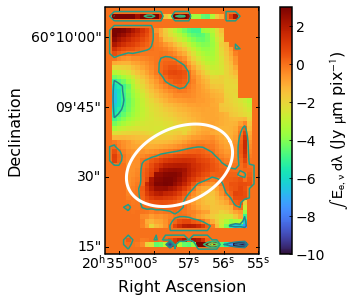

In [1170]:
if(ellipse == False):
    plot_linemap(loaddir, hdulist, center_x, center_y, n, central_wav, r, corrected)
    
else:
    plot_elliptical_linemap(loaddir, hdulist, center_x, center_y, n, central_wav, r_x, r_y, theta, corrected)

Configuration 1

In [1171]:
savedir_1 = loaddir + str(1) + '/' 

In [1172]:
config_1 = np.loadtxt(savedir_1 + 'config_' + str(1) + '.txt', comments="#", delimiter=",", unpack=False)

lower_ind_1 = int(config_1[0])
upper_ind_1 = int(config_1[1])
left_num_1 = int(config_1[2])
right_num_1 = int(config_1[3])
smooth_param_1 = bool(config_1[4])

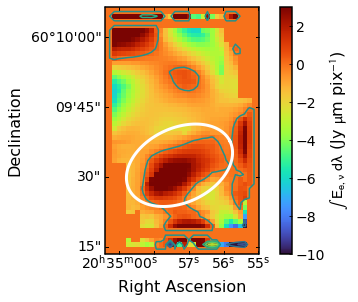

In [1173]:
if(ellipse == False):
    plot_reduced_linemap(savedir_1, hdulist, center_x, center_y, central_wav, lower_ind_1, upper_ind_1,
                         left_num_1, right_num_1, r, corrected)
    
else:
    plot_reduced_elliptical_linemap(savedir_1, hdulist, center_x, center_y, central_wav, lower_ind_1, upper_ind_1,
                                    left_num_1, right_num_1, r_x, r_y, theta, corrected)    

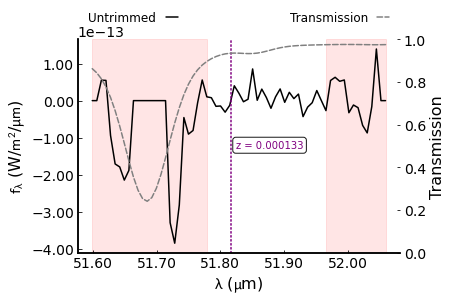

In [1174]:
plot_untrimmed_spectrum(wavelengths, central_densities_untrimmed, lower_ind_1, upper_ind_1, savedir_1, transmissions, 
                        z, central_wav, wav_diff, 1)

In [1175]:
wavelengths_trimmed_1, transmissions_trimmed_1, central_densities_unsmooth_1, central_densities_trimmed_1 = trim_spectrum(lower_ind_1, upper_ind_1, 
                                                                                                                          wavelengths,
                                                                                                                          transmissions,
                                                                                                                          central_densities_untrimmed,
                                                                                                                          central_wav,
                                                                                                                          smooth_param_1)

In [1176]:
idcont_1, central_densities_trimmed_continuum_1, cont_params_1, cont_errors_1 = identify_continuum(left_num_1, right_num_1, 
                                                                                                 wavelengths_trimmed_1, 
                                                                                                 central_densities_trimmed_1)




print(cont_params_1)
print(cont_errors_1)

[ 8.67606919e-15 -4.52989358e-13]
[1.70646998e-14 8.85514715e-13]


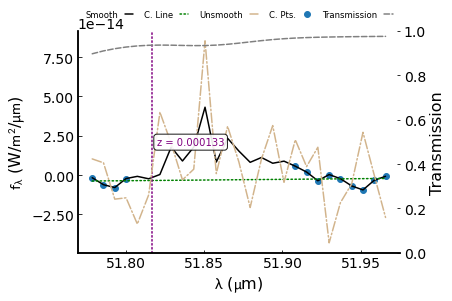

In [1177]:
plot_trimmed_spectrum_continuum_line(wavelengths_trimmed_1, central_densities_trimmed_1,
                                    central_densities_trimmed_continuum_1, cont_params_1, savedir_1,
                                    central_densities_unsmooth_1, smooth_param_1, transmissions_trimmed_1,
                                    z, central_wav, wav_diff,
                                    ((wavelengths_trimmed_1[-1]-wavelengths_trimmed_1[0])/(wavelengths[-1]-wavelengths[0])),
                                    modelled_continuum)

In [1178]:
id_act_1, wavelengths_act_1, central_densities_continuum_subtracted_act_1, central_densities_unsmooth_continuum_subtracted_act_1, transmissions_act_1 = subtract_continuum(central_densities_trimmed_continuum_1, 
                                                                           cont_params_1, wavelengths_trimmed_1, 
                                                                           central_densities_trimmed_1, 
                                                                           central_densities_unsmooth_1, 
                                                                           smooth_param_1, transmissions_trimmed_1, modelled_continuum)

In [1179]:
fit_params_1, fit_errors_1 = fit_gaussian(central_wav, wavelengths_act_1, central_densities_continuum_subtracted_act_1)

print(fit_params_1)
print(fit_errors_1)

[2.63700168e-14 5.18560465e+01 2.35463059e-02]
[4.68162610e-15 4.81764650e-03 5.08894158e-03]


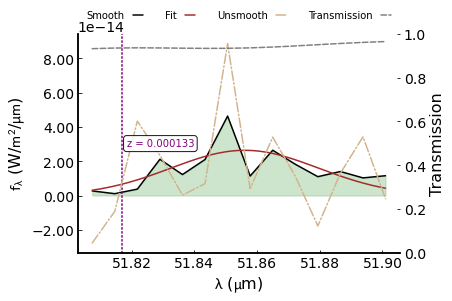

In [1180]:
plot_fit_continuum_subtracted_spectrum(wavelengths_act_1, fit_params_1, 
                                       central_densities_continuum_subtracted_act_1, savedir_1,
                                       central_densities_unsmooth_continuum_subtracted_act_1, smooth_param_1,
                                       transmissions_act_1, wav_del, 
                                       z, central_wav, wav_diff,
                                       ((wavelengths_act_1[-1]-wavelengths_act_1[0])/(wavelengths[-1]-wavelengths[0])))

In [1181]:
wavelength_range_1, cont_line_trimmed_1, fitted_central_densities_act_1 = overlay(wavelengths_trimmed_1, cont_params_1,
                                                                                  fit_params_1, wav_del, transmissions_trimmed_1, modelled_continuum)

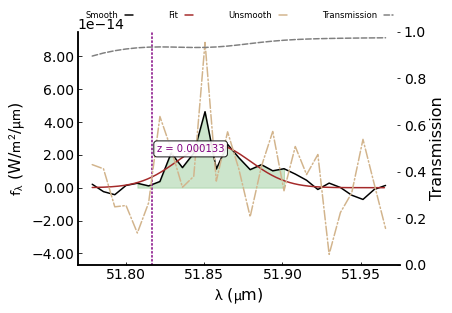

In [1182]:
plot_sub_spectrum(wavelengths_trimmed_1, transmissions_trimmed_1, central_densities_trimmed_1,
                  cont_params_1, fit_params_1, savedir_1, central_densities_unsmooth_1, smooth_param_1,
                  idcont_1, wav_del, z, central_wav, wav_diff,
                  ((wavelengths_trimmed_1[-1]-wavelengths_trimmed_1[0])/(wavelengths[-1]-wavelengths[0])), modelled_continuum)

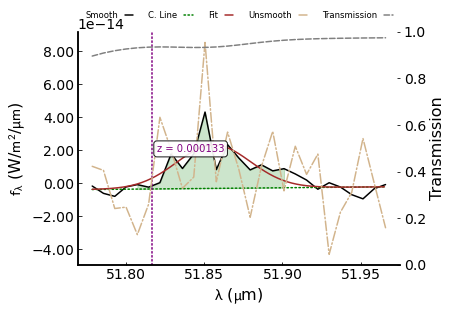

In [1183]:
plot_final_spectrum(wavelengths_trimmed_1, transmissions_trimmed_1, central_densities_trimmed_1,
                    cont_params_1, fit_params_1, savedir_1, central_densities_unsmooth_1, smooth_param_1,
                    idcont_1, wav_del, z, central_wav, wav_diff,
                    ((wavelengths_trimmed_1[-1]-wavelengths_trimmed_1[0])/(wavelengths[-1]-wavelengths[0])), modelled_continuum)

In [1184]:
flux_continuum_1, flux_obs_1, flux_obs_sub_1, flux_fit_1, flux_fit_sub_1, flux_err_1 = compute_fluxes(fit_params_1, cont_params_1,
                                                                                          wavelengths_trimmed_1, 
                                                                                          wavelength_range_1, 
                                                                                          central_densities_trimmed_continuum_1, 
                                                                                          central_densities_trimmed_1, 
                                                                                          fitted_central_densities_act_1,
                                                                                          left_num_1, right_num_1,
                                                                                          wav_diff, wav_del, transmissions_trimmed_1, modelled_continuum)

In [1185]:
avg_flux_trans_1 = 1
avg_cont_trans_1 = 1
avg_total_trans_1 = 1

if(corrected == False):
    
    not_idcont_1 = [not x for x in idcont_1]
    
    avg_flux_trans_1 = np.average(transmissions_act_1)
    avg_cont_trans_1 = np.average(transmissions_trimmed_1[not_idcont_1])
    avg_total_trans_1 = np.average(transmissions_trimmed_1)

In [1186]:
cent_1 = fit_params_1[1]
err_cent_1 = fit_errors_1[1]

width_1 = fit_params_1[2]
err_width_1 = fit_errors_1[2]

flux_1 = flux_obs_sub_1/10**(-17)
err_flux_1 = flux_err_1/10**(-17)

cont_flux_1 = flux_continuum_1/10**(-17)

cont_1 = np.nanmean(central_densities_trimmed_continuum_1/10**(-15))

if(modelled_continuum):
    cont_1 = np.nanmean(np.multiply(central_densities_trimmed_continuum_1, transmissions_trimmed_1)/10**(-15))

if(corrected == False):
    flux_1 /= avg_flux_trans_1
    err_flux_1 /= avg_flux_trans_1
    cont_flux_1 /= avg_total_trans_1
    cont_1 /= avg_cont_trans_1

In [1187]:
print('Central Wavelength (microns)')
print('---')
print(str(round(cent_1, 2)) + ' +- ' + str(round(err_cent_1, 4)))

print("")

print('Gaussian Width (microns)')
print('---')
print(str(round(width_1, 2)) + ' +- ' + str(round(err_width_1, 4)))

print("")

print('Flux (1e-17 W/m^2)')
print('---')
print(str(round(flux_1, 2)) + ' +- ' + str(round(err_flux_1, 2)))

print("")

print('Continuum Flux (1e-17 W/m^2)')
print('---')
print(str(round(cont_flux_1, 2)))

print("")

print('Continuum (1e-15 W/m^2/micron)')
print('---')
print(np.round(cont_1, 2))

Central Wavelength (microns)
---
51.86 +- 0.0048

Gaussian Width (microns)
---
0.02 +- 0.0051

Flux (1e-17 W/m^2)
---
139.05 +- 10.28

Continuum Flux (1e-17 W/m^2)
---
-55.08

Continuum (1e-15 W/m^2/micron)
---
-2.77


Configuration 2

In [1188]:
savedir_2 = loaddir + str(2) + '/' 

In [1189]:
config_2 = np.loadtxt(savedir_2 + 'config_' + str(2) + '.txt', comments="#", delimiter=",", unpack=False)

lower_ind_2 = int(config_2[0])
upper_ind_2 = int(config_2[1])
left_num_2 = int(config_2[2])
right_num_2 = int(config_2[3])
smooth_param_2 = bool(config_2[4])

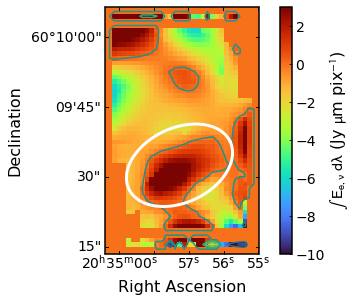

In [1190]:
if(ellipse == False):
    plot_reduced_linemap(savedir_2, hdulist, center_x, center_y, central_wav, lower_ind_2, upper_ind_2, 
                         left_num_2, right_num_2, r, corrected)
    
else:
    plot_reduced_elliptical_linemap(savedir_2, hdulist, center_x, center_y, central_wav, lower_ind_2, upper_ind_2,
                                    left_num_2, right_num_2, r_x, r_y, theta, corrected)    

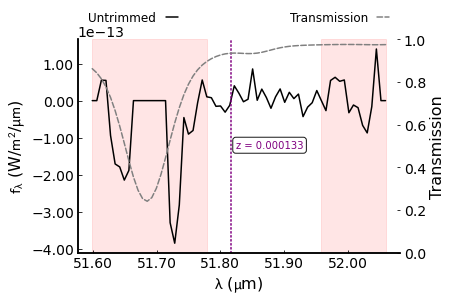

In [1191]:
plot_untrimmed_spectrum(wavelengths, central_densities_untrimmed, lower_ind_2, upper_ind_2, savedir_2, transmissions,
                        z, central_wav, wav_diff, 1)

In [1192]:
wavelengths_trimmed_2, transmissions_trimmed_2, central_densities_unsmooth_2, central_densities_trimmed_2 = trim_spectrum(lower_ind_2, upper_ind_2, 
                                                                                                                          wavelengths,
                                                                                                                          transmissions,
                                                                                                                          central_densities_untrimmed,
                                                                                                                          central_wav,
                                                                                                                          smooth_param_2)

In [1193]:
idcont_2, central_densities_trimmed_continuum_2, cont_params_2, cont_errors_2 = identify_continuum(left_num_2, right_num_2, 
                                                                                 wavelengths_trimmed_2, 
                                                                                 central_densities_trimmed_2)

print(cont_params_2)
print(cont_errors_2)

[ 2.02290179e-14 -1.05154316e-12]
[1.51782910e-14 7.87532063e-13]


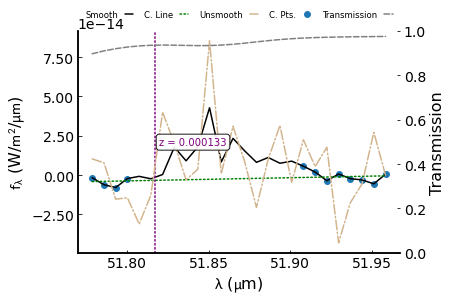

In [1194]:
plot_trimmed_spectrum_continuum_line(wavelengths_trimmed_2, central_densities_trimmed_2,
                                    central_densities_trimmed_continuum_2, cont_params_2, savedir_2,
                                    central_densities_unsmooth_2, smooth_param_2, transmissions_trimmed_2,
                                    z, central_wav, wav_diff,
                                    ((wavelengths_trimmed_2[-1]-wavelengths_trimmed_2[0])/(wavelengths[-1]-wavelengths[0])), modelled_continuum)

In [1195]:
id_act_2, wavelengths_act_2, central_densities_continuum_subtracted_act_2, central_densities_unsmooth_continuum_subtracted_act_2, transmissions_act_2 = subtract_continuum(central_densities_trimmed_continuum_2, 
                                                                           cont_params_2, wavelengths_trimmed_2, 
                                                                           central_densities_trimmed_2, 
                                                                           central_densities_unsmooth_2, 
                                                                           smooth_param_2, transmissions_trimmed_2,
                                                                           modelled_continuum)

In [1196]:
fit_params_2, fit_errors_2 = fit_gaussian(central_wav, wavelengths_act_2, central_densities_continuum_subtracted_act_2)

print(fit_params_2)
print(fit_errors_2)

[2.60148088e-14 5.18553130e+01 2.28279882e-02]
[4.64960876e-15 4.69963732e-03 4.90965897e-03]


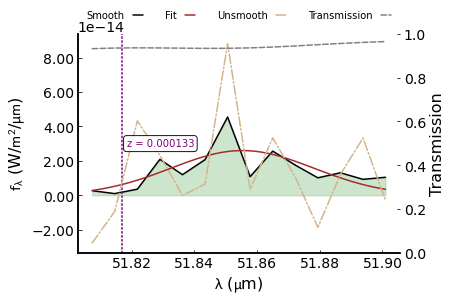

In [1197]:
plot_fit_continuum_subtracted_spectrum(wavelengths_act_2, fit_params_2, 
                                       central_densities_continuum_subtracted_act_2, savedir_2,
                                       central_densities_unsmooth_continuum_subtracted_act_2, smooth_param_2,
                                       transmissions_act_2, wav_del,
                                       z, central_wav, wav_diff,
                                       ((wavelengths_act_2[-1]-wavelengths_act_2[0])/(wavelengths[-1]-wavelengths[0])))

In [1198]:
wavelength_range_2, cont_line_trimmed_2, fitted_central_densities_act_2 = overlay(wavelengths_trimmed_2, cont_params_2,
                                                                                  fit_params_2, wav_del, transmissions_trimmed_2, modelled_continuum)

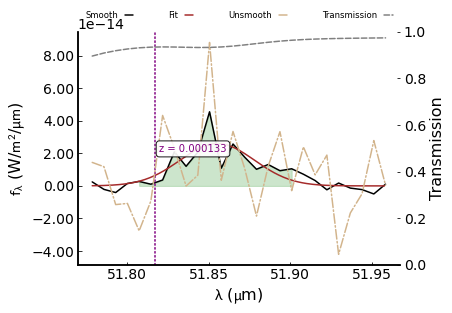

In [1199]:
plot_sub_spectrum(wavelengths_trimmed_2, transmissions_trimmed_2, central_densities_trimmed_2,
                  cont_params_2, fit_params_2, savedir_2, central_densities_unsmooth_2, smooth_param_2,
                  idcont_2, wav_del, z, central_wav, wav_diff,
                  ((wavelengths_trimmed_2[-1]-wavelengths_trimmed_2[0])/(wavelengths[-1]-wavelengths[0])), modelled_continuum)

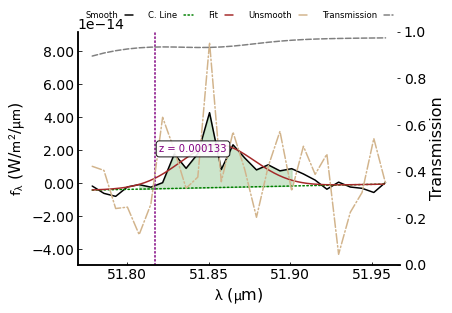

In [1200]:
plot_final_spectrum(wavelengths_trimmed_2, transmissions_trimmed_2, central_densities_trimmed_2,
                    cont_params_2, fit_params_2, savedir_2, central_densities_unsmooth_2, smooth_param_2,
                    idcont_2, wav_del, z, central_wav, wav_diff,
                    ((wavelengths_trimmed_2[-1]-wavelengths_trimmed_2[0])/(wavelengths[-1]-wavelengths[0])), modelled_continuum)

In [1201]:
flux_continuum_2, flux_obs_2, flux_obs_sub_2, flux_fit_2, flux_fit_sub_2, flux_err_2 = compute_fluxes(fit_params_2, cont_params_2,
                                                                                          wavelengths_trimmed_2, 
                                                                                          wavelength_range_2, 
                                                                                          central_densities_trimmed_continuum_2,
                                                                                          central_densities_trimmed_2, 
                                                                                          fitted_central_densities_act_2,
                                                                                          left_num_2, right_num_2,
                                                                                          wav_diff, wav_del,
                                                                                          transmissions_trimmed_2, modelled_continuum)

In [1202]:
avg_flux_trans_2 = 2
avg_cont_trans_2 = 2
avg_total_trans_2 = 1

if(corrected == False):
    
    not_idcont_2 = [not x for x in idcont_2]
    
    avg_flux_trans_2 = np.average(transmissions_act_2)
    avg_cont_trans_2 = np.average(transmissions_trimmed_2[not_idcont_2])
    avg_total_trans_2 = np.average(transmissions_trimmed_2)

In [1203]:
cent_2 = fit_params_2[1]
err_cent_2 = fit_errors_2[1]

width_2 = fit_params_2[2]
err_width_2 = fit_errors_2[2]

flux_2 = flux_obs_sub_2/10**(-17)
err_flux_2 = flux_err_2/10**(-17)

cont_flux_2 = flux_continuum_2/10**(-17)

cont_2 = np.nanmean(central_densities_trimmed_continuum_2/10**(-15))

if(modelled_continuum):
    cont_2 = np.nanmean(np.multiply(central_densities_trimmed_continuum_2, transmissions_trimmed_2)/10**(-15))

if(corrected == False):
    flux_2 /= avg_flux_trans_2
    err_flux_2 /= avg_flux_trans_2
    cont_flux_2 /= avg_total_trans_2
    cont_2 /= avg_cont_trans_2

In [1204]:
print('Central Wavelength (microns)')
print('---')
print(str(round(cent_2, 2)) + ' +- ' + str(round(err_cent_2, 4)))

print("")

print('Gaussian Width (microns)')
print('---')
print(str(round(width_2, 2)) + ' +- ' + str(round(err_width_2, 4)))

print("")

print('Flux (1e-17 W/m^2)')
print('---')
print(str(round(flux_2, 2)) + ' +- ' + str(round(err_flux_2, 2)))

print("")

print('Continuum Flux (1e-17 W/m^2)')
print('---')
print(str(round(cont_flux_2, 2)))

print("")

print('Continuum (1e-15 W/m^2/micron)')
print('---')
print(np.round(cont_2, 2))

Central Wavelength (microns)
---
51.86 +- 0.0047

Gaussian Width (microns)
---
0.02 +- 0.0049

Flux (1e-17 W/m^2)
---
134.89 +- 8.3

Continuum Flux (1e-17 W/m^2)
---
-41.26

Continuum (1e-15 W/m^2/micron)
---
-1.95


Final results

In [1205]:
flux = 0.5*(flux_1 + flux_2)
flux_err = np.abs(flux_1 - flux_2) + err_flux_1 + err_flux_2

cont_flux = 0.5*(cont_flux_1 + cont_flux_2)
cont_flux_err = np.abs(cont_flux_1 - cont_flux_2)

cont = 0.5*(cont_1 + cont_2)
cont_err = np.abs(cont_1 - cont_2)

print('Flux (1e-17 W/m^2)')
print('---')
print(str(round(flux, 2)) + ' +- ' + str(round(flux_err, 2)))

print("")

print('Continuum Flux (1e-17 W/m^2)')
print('---')
print(str(round(cont_flux, 2)) + ' +- ' + str(round(cont_flux_err, 2)))

print("")

print('Continuum (1e-15 W/m^2/micron)')
print('---')
print(str(round(cont, 2)) + ' +- ' + str(round(cont_err, 2)))

Flux (1e-17 W/m^2)
---
136.97 +- 22.74

Continuum Flux (1e-17 W/m^2)
---
-48.17 +- 13.82

Continuum (1e-15 W/m^2/micron)
---
-2.36 +- 0.82


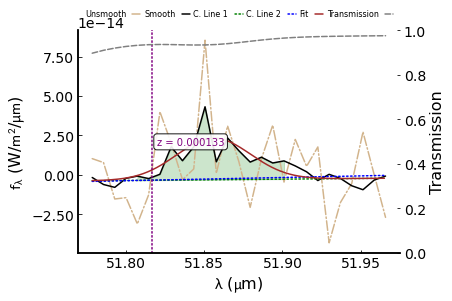

In [1206]:
if(flux_2 >= flux_1):
    plot_cumulative_spectrum(wavelengths_trimmed_2, transmissions_trimmed_2, central_densities_trimmed_2,
                            cont_params_2, cont_params_1, fit_params_2, loaddir, central_densities_unsmooth_2,
                            smooth_param_2, idcont_2, wav_del, z, central_wav, wav_diff,
                            ((wavelengths_trimmed_2[-1]-wavelengths_trimmed_2[0])/(wavelengths[-1]-wavelengths[0])),
                            modelled_continuum)
    
else:
    plot_cumulative_spectrum(wavelengths_trimmed_1, transmissions_trimmed_1, central_densities_trimmed_1,
                            cont_params_1, cont_params_2, fit_params_1, loaddir, central_densities_unsmooth_1,
                            smooth_param_1, idcont_1, wav_del, z, central_wav, wav_diff,
                            ((wavelengths_trimmed_1[-1]-wavelengths_trimmed_1[0])/(wavelengths[-1]-wavelengths[0])),
                            modelled_continuum)